## Project name: Flag Database Fun Time

### Team Leader: Cole Polychronis

### Team Members: Merritt Ruthrauff, Kelsey Henrichsen, Jasmine Boonyakiti

#### Data Description:

Our datasets has 194 records. Each record is described by these values:

**Response Variable：**
* Religion of a Country      

**Predictor Variables:**
1. Name of country   
2. Continent of country                  
3. Quadrant of the world (relative to Greenwich and the Equator)   
4. Area (in millions of square kilometers)                           
5. Population (in millions) 
6. Language spoken  
7. Number of vertical bars on flag              
8. Number of horizontal stripes on flag         
9. Number of colors on flag    
10. Presence of red on flag
11. Presence of green on flag
12. Presence of blue on flag
13. Presence of gold on flag
14. Presence of white on flag
15. Presence of black on flag
16. Presence of orange on flag
17. Main color on flag
18. Number of circles on flag
19. Number of crosses on flag
20. Number of saltires (diagonal crosses) on flag
21. Number of quartered sections
22. Number of suns or stars on flag
23. Presence of crescent on flag
24. Presence of triangles on flag
25. Presence of inanimate icon on flag
26. Presence of animate icon on flag
27. Presence of text on flag
28. Color in top left of flag
29. Color in bottom right of flag

# Step 1.1: Load Data

#### Because our data could not be downloaded from the UCI site, we created a very basic webcrawler to pull the dataset off of the UCI page. Since this gave us a list where some attributes were connected by \n, we built a function to seperate these connected values. We then grouped these attributes together into the correct number of rows and converted them into a dataframe.

In [3]:
# basic webcrawler to peel data off of UCI webpage
from lxml import html
import requests
page = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data')
tree = html.fromstring(page.text)
info = tree.xpath('//text()')
info = info[0].split(',')

# method to untangle values connected by \n (EX: 'green\nAlbania')
def untangle(arr):
    untangled = []
    for el in arr:
        try: 
            ind = el.index('\n')
        except ValueError:
            ind = -1
        if ind == -1:
            untangled.append(el)
        else:
            untangled.append(el[:ind])
            untangled.append(el[ind+1:])
    return untangled

# group data into rows and convert to a Dataframe
untangled = untangle(info)
usable = [untangled[i:i + 30] for i in range(0, len(untangled), 30)]
import pandas as pd
df = pd.DataFrame(usable)

# remove last buffer row, which contains all None
df = df[:-1]
# convert all columns that should be numeric to ints (as they are currently all strings)
indices = []
for i in range(29):
    if i != 0 and i != 17 and i != 28 and i != 29:
        indices.append(i)
df[indices] = df[indices].apply(pd.to_numeric)

# Step 1.2: Preprocessing
#### This data is separated into each of the columns that represent the data we are going to analyze for each country. i.e. Area, population, religion, etc. In order to get the categorical variables to work with our dataset, we had to convert them using the .get_dummies to convert the data to use for the DecisionTreeClassifier. In order for the tree to make sense on the graphviz, there needed to be a modification of the column names.

In [4]:
# convert categorical variables to "dummy" variables so that they can be used by the DecisionTreeClassifier
df = pd.get_dummies(df, prefix=['continent', 'quadrant', 'language','mainColor','topLeftColor','bottomRightColor'], columns=[1, 2, 5, 17, 28, 29])

In [5]:
# select data and target sets
data = df.drop(df.columns[[0,6]], axis=1)
target = df[6]

# df.columns=['country','continent','quadrant','area (thousands of square km)','population (millions)','language','religion','bars','stripes','numOfColors','red','green','blue','gold','white','black','orange','mainColor','numOfCircles','numOfCrosses','numOfSaltires','numOfQuarters','numOfSunStars','crescent','triangle','icon','animate','text','topLeftColor','botRightColor']

df.columns=['country','area (thousands of square of km)', 'population (millions)','religion','bars','stripes','numOfColors','red','green','blue','gold','white','black','orange','numOfCircles','numOfCrosses','numOfSaltires','numOfQuarters','numOfSunStars','crescent','triangle','icon','animate','text','inN.America','inS.America','inEurope','inAfrica','inAsia','inOceania','inNE','inSE','inSW','inNW','english','spanish','french','german','slavic','otherIndoEuropean','chinese','arabic','Japanese/Turkish/Finnish/Magyar','other',
            'mainColor_black','mainColor_blue','mainColor_brown','mainColor_gold','mainColor_green','mainColor_orange','mainColor_red','mainColor_white','topLeftColor_black','topLeftColor_blue','topLeftColor_gold','topLeftColor_green','topLeftColor_orange','topLeftColor_red','topLeftColor_white','bottomRightColor_black',
            'bottomRightColor_blue','bottomRightColor_brown',
            'bottomRightColor_gold','bottomRightColor_green',
            'bottomRightColor_orange','bottomRightColor_red',
            'bottomRightColor_white']
df.head()


,country,area (thousands of square of km),population (millions),religion,bars,stripes,numOfColors,red,green,blue,...,topLeftColor_red,topLeftColor_white,bottomRightColor_black,bottomRightColor_blue,bottomRightColor_brown,bottomRightColor_gold,bottomRightColor_green,bottomRightColor_orange,bottomRightColor_red,bottomRightColor_white
0,Afghanistan,648,16,2,0,3,5,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,Albania,29,3,6,0,0,3,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,Algeria,2388,20,2,2,0,3,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,American-Samoa,0,0,1,0,0,5,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,Andorra,0,0,0,3,0,3,1,0,1,...,0,0,0,0,0,0,0,0,1,0


# Step 1.3: Modeling using Decision Tree
#### For this part, we had to put the data that we had created above into the Decision Tree Classifier to finally see the output of the data. Instead of the data being used as whole numbers, the data was converted to percentages to show the importance of each category. With the output given, the population data is the most important feauture when comparing the religion of a country to the rest of the data.

In [6]:
# create Decision Tree Classifier and determine which features are most important
from sklearn import tree
import numpy as np
clf = tree.DecisionTreeClassifier()
clf.fit(data,target)

y_pred = clf.predict(data)
classif_rate = np.mean(y_pred.ravel() == target.ravel()) * 100
print("classif_rate for %s : %f " % ('RandomForestClassifier', classif_rate))
print clf.feature_importances_

classif_rate for RandomForestClassifier : 100.000000 
[ 0.          0.          0.88473793  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.10559109  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.00967099  0.          0.          0.          0.          0.
  0.          0.        ]


# Step 1.4: Visualization
#### The final step was to import the graphviz package and use it to take the information and make a tree to display the. The information that is displayed is the decision tree from above (clf), the table that holds the information (feature_names), and the religion from each country (class_names). With the categorical variables such as the inS.America, the value is <= 0.5 which means the value is 0 or not true in this case. When looking at any of the data that has a value of > 0 which makes the value true. 

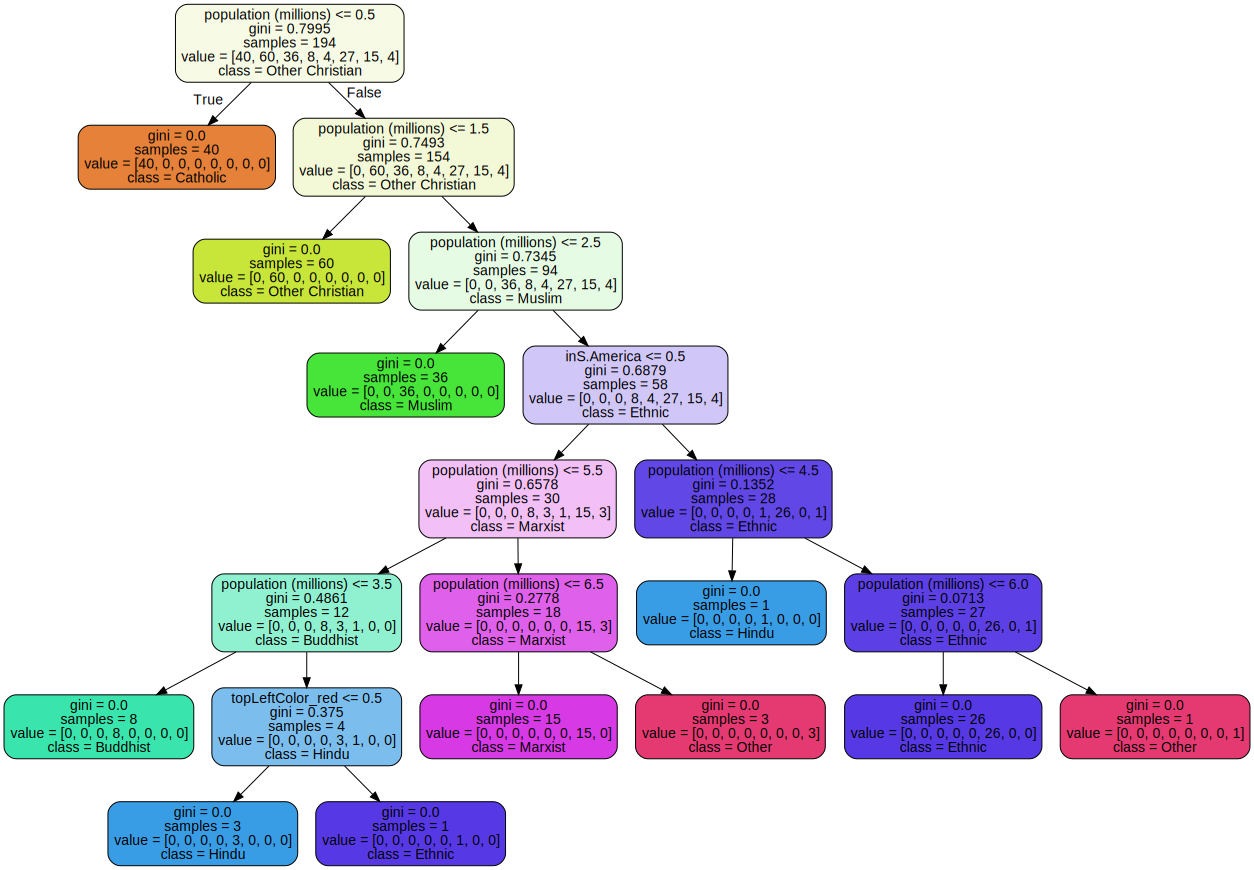

In [7]:
# visualize the decision tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,
#                                max_depth=5,
                               filled=True, rounded=True,
                               feature_names=df.columns,
                               class_names=['Catholic','Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic', 'Marxist', 'Other']) 
graph = graphviz.Source(dot_data)  
graph

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC(), KNeighborsClassifier()]
tuned_parameters = [{'criterion':["gini","entropy"]}, # parameters for decision tree
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 3]}, # parameters for random forest
                   {'n_estimators':[10,20,30,40], 'max_depth':[None, 3]}, # parameters for gradient boost
                   {'decision_function_shape':['ovo'], 'degree':[1,2,3,4,5]}, # parameters for support vector machine
                   {'n_neighbors':[5,10,15], 'algorithm':['auto','ball_tree','kd_tree']}] # parameters for k nearest neighbors

for model, tuned_parameter in zip(models, tuned_parameters):
    classify = GridSearchCV(model,tuned_parameter,cv=4,verbose=1)
    classify.fit(data,target)
    print classify.best_params_
    print classify.best_score_ 

Fitting 4 folds for each of 2 candidates, totalling 8 fits
{'criterion': 'entropy'}
1.0
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


{'n_estimators': 30, 'max_depth': None}
0.876288659794
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.7s finished


{'n_estimators': 30, 'max_depth': 3}
0.994845360825
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.3s finished


{'decision_function_shape': 'ovo', 'degree': 1}
0.438144329897
Fitting 4 folds for each of 9 candidates, totalling 36 fits
{'n_neighbors': 5, 'algorithm': 'auto'}
0.376288659794


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.4s finished


In [9]:
from sklearn.metrics import r2_score, accuracy_score

classify = DecisionTreeClassifier(criterion = 'entropy')
classify.fit(data,target)
yhat=classify.predict(data)
print accuracy_score(target,yhat) 

1.0


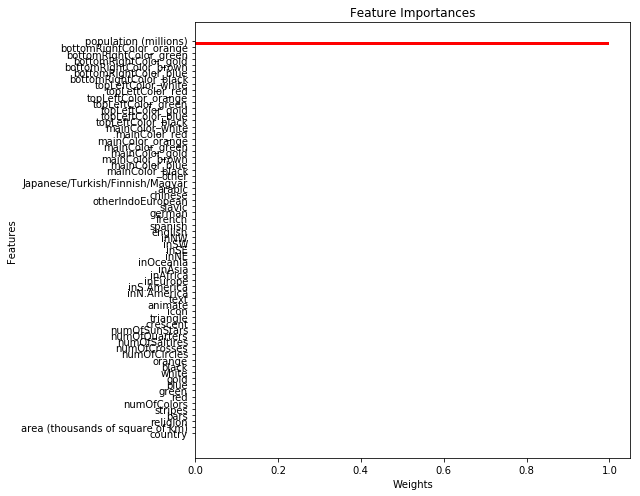

In [10]:
import matplotlib.pyplot as plt
features= df.columns.values
value = classify.feature_importances_
ind=sorted(range(len(value)),reverse=False,key=lambda k: value[k])
features=features[ind]
value=sorted(value,reverse=False)
ind=np.array(range(len(features)))
plt.rcParams['figure.figsize'] = (9,7)
plt.barh(bottom=ind,height=0.5,width=value,color='r')
plt.yticks(ind+0.5,features)
plt.xlabel('Weights')
plt.ylabel('Features')
plt.title('Feature Importances')
#plt.subplots_adjust(left=0.2)
plt.tight_layout()
#plt.savefig('feature_importances.png', format='png', dpi=300)
plt.show()

In [28]:
import plotly.offline as off

off.init_notebook_mode(connected=True)

subject = df.columns.values
score = classify.feature_importances_

data = [dict(
  type = 'scatter',
  x = subject,
  y = score,
  mode = 'markers',
  transforms = [dict(
    type = 'groupby',
    groups = subject,
    styles = [
        dict(target = 'subject', value = dict(marker = dict(color = 'blue'))),
        dict(target = 'subject', value = dict(marker = dict(color = 'red'))),
        dict(target = 'subject', value = dict(marker = dict(color = 'black')))
    ]
  )]
)]

off.iplot({'data': data}, validate=False)